In [1]:
import xara
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1
from scipy.ndimage import map_coordinates
import ExoRIM as exo
from ExoRIM.definitions import mas2rad, rad2mas
import tensorflow as tf
# from celluloid import Camera
from IPython.display import HTML
from matplotlib.lines import Line2D
# from joypy import joyplot
import pandas as pd
tf.keras.backend.set_floatx('float32')
%matplotlib inline

In [2]:
# Defines physical variables
N = 21
L = 6
pixels = 128
wavel = 0.5e-6
# fov = 50 # mas
plate_scale = 0.3 #2.2 * 1000 / 2048 * 3 # James Webb plate scale, #exo.definitions.rad2mas(1.22 * wavel / 4 / L)/10 # mas / pixel at the diffraction limit
var = 1
ISZ = 32  # number of pixels for the image

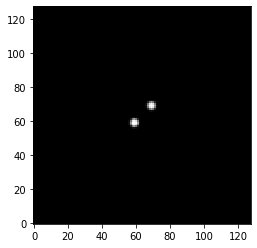

In [3]:
image_coords = np.arange(pixels) - pixels / 2.
xx, yy = np.meshgrid(image_coords, image_coords)
image1 = np.zeros_like(xx)
rho_squared = (xx + 5) ** 2 + (yy + 5) ** 2
radius = 2 #pixels
a = radius*mas2rad(plate_scale)
image1 += np.exp(-0.5 * rho_squared**2/radius**4)
rho_squared = (xx - 5) ** 2 + (yy - 5) ** 2
image1 += np.exp(-0.5 * rho_squared**2/radius**4)


# image1 += np.sqrt(rho_squared) < radius
# rho_squared = (xx - 10) ** 2 + (yy -10) ** 2/3
# image1 += np.sqrt(rho_squared) < 2
# rho_squared = (xx - 5) ** 2 + (yy -10) ** 2/6
# image1 += np.sqrt(rho_squared) < 5
# image1 += np.logical_and(rho_squared > radius**2, rho_squared < radius**2 + radius) * 0.1

im = plt.imshow(image1, cmap="gray")


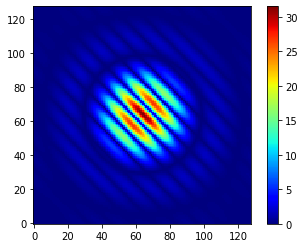

In [4]:
fft = np.abs(np.fft.fftshift(np.fft.fft2(image1)))


# image1 += np.sqrt(rho_squared) < radius
# rho_squared = (xx - 10) ** 2 + (yy -10) ** 2/3
# image1 += np.sqrt(rho_squared) < 2
# rho_squared = (xx - 5) ** 2 + (yy -10) ** 2/6
# image1 += np.sqrt(rho_squared) < 5
# image1 += np.logical_and(rho_squared > radius**2, rho_squared < radius**2 + radius) * 0.1

im = plt.imshow(fft, cmap="jet")
plt.colorbar(im)

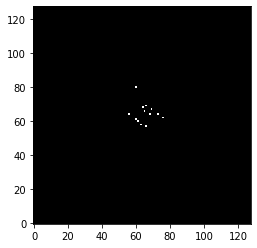

In [5]:
# x = (L + np.random.normal(0, var, N)) * np.cos(2 * np.pi * np.arange(N) / N)
# y = (L + np.random.normal(0, var, N)) * np.sin(2 * np.pi * np.arange(N) / N)
# circle_mask = np.array([x, y]).T
mask = np.random.normal(0, L, (N, 2))

image_coords = np.arange(pixels) - pixels / 2.
xx, yy = np.meshgrid(image_coords, image_coords)
image = np.zeros_like(xx)
for x in mask:
    rho_squared = np.sqrt((xx-x[0]) ** 2 + (yy - x[1]) ** 2)
    image += np.sqrt(rho_squared) < 0.7
plt.imshow(image, cmap="gray")

In [6]:
uv = baselines.UVC
rho = np.hypot(uv[:, 0], uv[:, 1])
fov = rad2mas(wavel/rho).max()
plate_scale = fov / pixels # mas
fftfreq = np.fft.fftshift(np.fft.fftfreq(pixels, plate_scale))

im = plt.imshow(np.abs(fft), cmap="jet", extent=[fftfreq.min(), fftfreq.max()]*2)
baselines = exo.operators.Baselines(mask_coordinates=mask)
ufreq = 1/rad2mas(1/baselines.UVC[:, 0]*wavel)
vfreq = 1/rad2mas(1/baselines.UVC[:, 1]*wavel)
plt.plot(ufreq, vfreq, "k.")
plt.colorbar(im)
plt.title("UV coverage")

NameError: name 'baselines' is not defined

In [ ]:
def bispectra(V):
    V1 = tf.einsum("ij, ...j -> ...i", V1_projector, V)
    V2 = tf.einsum("ij, ...j -> ...i", V2_projector, V)
    V3 = tf.einsum("ij, ...j -> ...i", V3_projector, V)
    return V1 * tf.math.conj(V2) * V3  # hack that works with baseline class! Be careful using other method

def zero_pad(image):
    return np.pad(image, pixels//2, 'constant', constant_values=0)

def zero_pad_over_batch(images):
    out = np.zeros((images.shape[0], 2*pixels, 2*pixels))
    out[:, pixels//2:-pixels//2, pixels//2:-pixels//2] = images 
    return out

def crop_image(image):
    return image[..., pixels//2:-pixels//2, pixels//2:-pixels//2]

# Test with zero padding
delta_x = mas2rad(plate_scale)
# B = exo.operators.Baselines(circle_mask)
B = exo.operators.Baselines(mask)
print(plate_scale)
print(exo.definitions.rad2mas(1.22 * wavel / 4 / L))
ndftm = exo.operators.NDFTM(B.UVC, wavel, pixels, plate_scale) * delta_x**2
ndftm_i = exo.operators.NDFTM(B.UVC, wavel, pixels, plate_scale, inv=True)
p = N * (N - 1) // 2
q = (N - 1) * (N - 2) // 2
# q = N * (N - 1) * (N - 2) // 6
mycomplex = exo.definitions.mycomplex
dtype = exo.definitions.dtype
baselines = exo.operators.Baselines(mask_coordinates=circle_mask)
CPO = exo.operators.closure_phase_operator(baselines)
# CPO = exo.operators.redundant_phase_closure_operator(baselines)
bisp_i = np.where(CPO != 0)
V1_i = (bisp_i[0][0::3], bisp_i[1][0::3])
V2_i = (bisp_i[0][1::3], bisp_i[1][1::3])
V3_i = (bisp_i[0][2::3], bisp_i[1][2::3])
V1_projector_np = np.zeros(shape=(q, p))
V1_projector_np[V1_i] += 1.0
V1_projector = tf.constant(V1_projector_np, dtype=mycomplex)
V2_projector_np = np.zeros(shape=(q, p))
V2_projector_np[V2_i] += 1.0
V2_projector = tf.constant(V2_projector_np, dtype=mycomplex)
V3_projector_np = np.zeros(shape=(q, p))
V3_projector_np[V3_i] += 1.0
V3_projector = tf.constant(V3_projector_np, dtype=mycomplex)
CPO = tf.constant(CPO, dtype=dtype)
A = tf.constant(ndftm, dtype=mycomplex)
# Discrete Fourier Transform Matrices for bispectra
A1 = tf.tensordot(V1_projector, A, axes=1)
A2 = tf.tensordot(V2_projector, A, axes=1)
A3 = tf.tensordot(V3_projector, A, axes=1)

In [ ]:

# V = ndftm.dot(zero_pad(image1).flatten())
V = ndftm.dot(image1.flatten())
phase_noise = np.random.normal(0, np.pi/3, size=[B.nbap])
visibility_phase_noise = np.einsum("ij, ...j -> ...i", B.BLM, phase_noise)

noisy_V = V * np.exp(1j * visibility_phase_noise)
psi = np.einsum("ij, ...j -> ...i", CPO.numpy(), np.angle(V))
noisy_psi = np.einsum("ij, ...j -> ...i", CPO.numpy(), np.angle(noisy_V))

Bisp = bispectra(V)
NoisyBisp = bispectra(noisy_V)


rho = np.sqrt(B.UVC[:, 0]**2 + B.UVC[:, 1]**2)/wavel
plt.title("Result of Discrete Fourier Transform")
plt.plot(rho, np.abs(V), "ko")
np.abs(V).min()

In [ ]:
plt.title("Analytical solution")
anal_sol = a*np.abs(j1(2*np.pi*a*rho))/rho
plt.plot(rho, anal_sol, "ko")

In [ ]:
plt.title("diff")
plt.plot(rho[:100], (np.abs(anal_sol - np.abs(V))/anal_sol)[:100]*100, "ko")
plt.ylabel("Percent")

B = V1 * V2.conj() * V3

In [ ]:
plt.plot(np.arange(Bisp.numpy().size), tf.math.angle(Bisp).numpy(), "k.")
print("Bispectra angles")

In [ ]:
plt.plot(np.arange(NoisyBisp.numpy().size), tf.math.angle(NoisyBisp).numpy(), "k.")
print("Noisy Bispectra angles")

In [ ]:
plt.plot(np.arange(NoisyBisp.numpy().size), tf.math.sin(tf.math.angle(NoisyBisp).numpy() - tf.math.angle(Bisp).numpy()), "k.")
print("Diff")

In [ ]:
plt.plot(np.arange(psi.size), psi, "k.")

In [ ]:
plt.plot(np.arange(noisy_psi.size), noisy_psi, "k.")

In [ ]:
plt.plot(np.arange(psi.size), 1 - np.cos(noisy_psi - psi), "k.")

In [ ]:
plt.plot(np.arange(psi.size), 1 - np.cos(psi - tf.math.angle(Bisp).numpy()), "k.")

In [ ]:
image_hat = np.fft.fftshift(np.fft.fft2(zero_pad(image)))[pixels//2:-pixels//2, pixels//2:-pixels//2]
plt.imshow(np.abs(image_hat), cmap="gray")

In [ ]:
def cast_to_complex_flatten(image):
    im = tf.dtypes.cast(image, mycomplex)
    im = tf.keras.layers.Flatten(data_format="channels_last")(im)
    return im

In [ ]:

def chisq_amp(image, A, amp, sigma):
    """Visibility Amplitudes (normalized) chi-squared"""
    sig = tf.cast(sigma, dtype)
    im = cast_to_complex_flatten(image)
    #amp_samples = tf.math.abs(tf.einsum("ij, ...j -> ...i", A, im))
    amp_samples = tf.einsum("ij, ...j -> ...i", A, im)
    amp_samples = amp_samples #* tf.math.exp(-1j * tf.math.angle(amp_samples[0]))
    amp_samples = tf.math.abs(amp_samples)
    return tf.math.reduce_mean(((amp - amp_samples)/sig)**2, axis=1)

def chisqgrad_amp(image, V, sigma, floor=1e-6):
    """The gradient of the amplitude chi-squared"""
    pix = pixels # since we zero pad
    amp = tf.cast(tf.math.abs(V), dtype)
    im = cast_to_complex_flatten(image)
    V_samples = tf.einsum("ij, ...j -> ...i", A, im)
    amp_samples = tf.math.abs(V_samples)
    den = tf.cast((sigma + floor)**2, dtype)
    product = (amp - amp_samples) / den / amp_samples
    product = tf.cast(product, mycomplex)
    adjoint = tf.transpose(tf.math.conj(A))
    out = -2.0 * tf.math.real(tf.einsum("ij, ...j -> ...i", adjoint, V_samples * product))
    out = tf.reshape(out, shape=[-1, pix, pix, 1])
    return out / amp.shape[1]

In [ ]:
def chisq_bis(image, B, sigma):
    """

    :param image: Image tensor
    :param Amatrices:
    :param B: Bispectrum projection matrix to project from complex visibilities to bispectrum ()
    :param bis:
    :param sigma:
    :return:
    """
    sig = tf.cast(sigma, dtype)
    im = cast_to_complex_flatten(image)
    V1 = tf.einsum("ij, ...j -> ...i", A1, im)
    V2 = tf.einsum("ij, ...j -> ...i", A2, im)
    V3 = tf.einsum("ij, ...j -> ...i", A3, im)
    B_sample = V1 * tf.math.conj(V2) * V3
    chisq = 0.5 * tf.reduce_mean(tf.math.square(tf.math.abs(B - B_sample)/sig), axis=1)
    return chisq

def chisqgrad_bis(image, B, sigma, floor=1e-6):
    """The gradient of the bispectrum chi-squared"""
    pix = pixels
    sig = tf.cast(sigma, mycomplex)
    im = cast_to_complex_flatten(image)
    einsum = "ij, ...j -> ...i"
    t_einsum = "ji, ...j -> ...i"
    V1 = tf.einsum(einsum, A1, im)
    V2 = tf.einsum(einsum, A2, im)
    V3 = tf.einsum(einsum, A3, im)
    B_samples = V1 * tf.math.conj(V2) * V3
    wdiff = tf.math.conj(B - B_samples)/(sig + floor)**2
    out = tf.einsum(t_einsum, A1, wdiff * V2 * V3)
    out = out +  tf.einsum(t_einsum, tf.math.conj(A2), wdiff * tf.math.conj(V1 * V3))
    out = out +  tf.einsum(t_einsum, A3, wdiff * V1 * V2)
    out = -tf.math.real(out) / B.shape[1]
    out = tf.reshape(out, shape=[-1, pix, pix, 1])
    return out


In [ ]:
def chisq_cphase(image, clphase, sigma):
    """Closure Phases (normalized) chi-squared"""
    sig = tf.cast(sigma, dtype)
    im = cast_to_complex_flatten(image)
    einsum = "ij, ...j -> ...i"
    V1 = tf.einsum(einsum, A1, im)
    V2 = tf.einsum(einsum, A2, im)
    V3 = tf.einsum(einsum, A3, im)
    clphase_samples = tf.math.angle(V1 * tf.math.conj(V2) * V3)
    chisq = tf.reduce_mean(((1 - tf.math.cos(clphase - clphase_samples)) / sig)**2, axis=1)
    return chisq

def gradchisq_cphase_auto(image, vis, sigma):
    im = tf.constant(image, dtype)
    with tf.GradientTape() as tape:
        tape.watch(im)
        chisq = chisq_cphase(im, tf.math.angle(bispectra(vis)), sigma)
    return tape.gradient(chisq, im)

def chisqgrad_cphase(image, clphase, sigma):
    """The gradient of the closure phase chi-squared"""
    pix = pixels
    im = cast_to_complex_flatten(image)
    einsum = "ij, ...j -> ...i"
    t_einsum = "ji, ...j -> ...i"
    V1 = tf.einsum(einsum, A1, im)
    V2 = tf.einsum(einsum, A2, im)
    V3 = tf.einsum(einsum, A3, im)
    B = V1 * tf.math.conj(V2) * V3
    clphase_samples = tf.math.angle(B)
    wdiff = tf.cast(tf.math.sin(clphase - clphase_samples)/sigma**2, mycomplex)
    out = tf.einsum(t_einsum, tf.math.conj(A1), wdiff / tf.math.conj(V1))
    out = out + tf.einsum(t_einsum, A2, wdiff / V2)
    out = out + tf.einsum(t_einsum, tf.math.conj(A3), wdiff / tf.math.conj(V3))
    out = -2. * tf.math.imag(out) / B.shape[1]
    out = tf.reshape(out, shape=[-1, pix, pix, 1])
    return out

In [ ]:
def chisq_vis(image, A, vis, sigma):
    sig = tf.cast(sigma, dtype)
    im = cast_to_complex_flatten(image)
    samples = tf.einsum("ij, ...j -> ...i", A, im)
    chisq = 0.5 * tf.reduce_mean((tf.math.abs(samples - vis) / sig)**2, axis=1)
    return chisq


def gradchisq_vis(image, vis, sigma, floor=1e-6):
    """The gradient of the visibility chi-squared"""
    pix = pixels
    sig = tf.cast(sigma + floor, mycomplex)  # prevent dividing by zero
    im = cast_to_complex_flatten(image)
    samples = tf.einsum("ij, ...j -> ...i", A, im)
    wdiff = (vis - samples)/(sig**2)
    out = -tf.math.real(tf.einsum("ji, ...j -> ...i", tf.math.conj(A), wdiff))
    out = tf.reshape(out, [-1, pix, pix, 1])
    return out / vis.shape[1]

def gradchisq_vis_auto(image, vis, sigma):
    im = tf.constant(image, dtype)
    with tf.GradientTape() as tape:
        tape.watch(im)
        chisq = chisq_vis(im, A, vis, sigma)
    return tape.gradient(chisq, im)

In [ ]:
def chisq_phases(image, A, vis, sigma):
    sig = tf.cast(sigma, dtype)
    im = cast_to_complex_flatten(image)
    samples = tf.einsum("ij, ...j -> ...i", A, im)
    chisq = 0.5 * tf.reduce_mean((tf.math.abs(samples - vis) / sig)**2, axis=1)
    return chisq

In [ ]:
def chisq_real_image(image, A, vis, sigma_r, sigma_i=None):
    if sigma_i is None:
        sigma_i = sigma_r
    sig_i = tf.cast(sigma_i, tf.float32)
    sig_r = tf.cast(sigma_r, tf.float32)
    im = cast_to_complex_flatten(image)
    samples = tf.einsum("ij, ...j -> ...i", A, im)
#     chisq = 0
    chisq_r = 0.5 * tf.reduce_mean(((tf.math.real(samples) - tf.cast(tf.math.real(vis), dtype)) / sig_r)**2, axis=1)
    chisq_i = 0.5 * tf.reduce_mean(((tf.math.imag(samples) - tf.cast(tf.math.imag(vis), dtype)) / sig_i)**2, axis=1)
    return (chisq_r, chisq_i)

def gradchisq_real_imag(image, A, vis, sigma_r, sigma_i=None):
    if sigma_i is None:
        sigma_i = sigma_r
    sig_i = tf.cast(sigma_i, tf.float64)
    sig_r = tf.cast(sigma_r, tf.float64)
    ima = tf.constant(image, tf.float64)
    with tf.GradientTape() as tape:
        tape.watch(ima)
#         im = exo.definitions.cast_to_complex_flatten(ima)
        samples = tf.einsum("ij, ...j -> ...i", tf.math.real(A), ima)
        chisq_r = 0.5 * tf.reduce_mean(((samples - tf.cast(tf.math.real(vis), tf.float64)) / sig_r)**2, axis=1)
    grad_real = tape.gradient(chisq_r, ima)
    with tf.GradientTape() as tape:
        tape.watch(ima)
#         im = exo.definitions.cast_to_complex_flatten(ima)
        samples = tf.einsum("ij, ...j -> ...i", tf.math.imag(A), tf.cast(ima, tf.float64 ))
        chisq_i = 0.5 * tf.reduce_mean(((samples - tf.cast(tf.math.imag(vis), tf.float64)) / sig_i)**2, axis=1)
    grad_imag = tape.gradient(chisq_i, ima)
    return grad_real, grad_imag

In [ ]:
batch = 20
# im_copies = zero_pad(image1).flatten().reshape((1, 4*image1.shape[0]**2)) 
im_copies = image1.flatten().reshape((1, image1.shape[0]**2)) 
im_copies = np.tile(im_copies, [batch, 1])
V_copies = V.reshape((1, V.shape[0]))
V_copies = np.tile(V_copies, [batch, 1])
V_copies = tf.cast(V_copies, exo.definitions.mycomplex)
B = bispectra(V_copies)
noise = im_copies + np.linspace(-50, 50, batch).reshape((batch, 1))
sigma = 0.1
log_likelihood = chisq_vis(noise, ndftm, V_copies, sigma).numpy()
llr, lli = chisq_real_image(noise, ndftm, V_copies, sigma)
chi_amp = chisq_amp(noise, ndftm, tf.math.abs(V_copies), sigma)
chi_bis = chisq_bis(noise, bispectra(V), sigma)
mse = np.mean((noise - im_copies)**2, axis=1)
plt.plot(np.linspace(-50, 50, batch) / 100, log_likelihood, color="k", label=r"$\chi^2_{vis}$")
plt.plot(np.linspace(-50, 50, batch) / 100, lli.numpy(), color="r", label=r"$\chi^2_{imag}$")
plt.plot(np.linspace(-50, 50, batch) / 100, llr.numpy(), color="b", label=r"$\chi^2_{real}$")
plt.plot(np.linspace(-50, 50, batch) / 100, chi_amp.numpy(), color="g", label=r"$\chi^2_{amp}$")
# plt.plot(np.linspace(-50, 50, 100) / 100, chi_bis.numpy(), color="m", label=r"$\chi^2_{bis}$")  # Some 10 order of magnitude higher! Swamps the signal from amp
# plt.plot(np.linspace(-50, 50, 100) / 100, mse, color="b", label=r"$\chi^2_{real}$")
plt.xlabel("Error amplitude")
plt.ylabel("Log likelihood")
plt.title(rf"White noise likelihood test with $\sigma$ = {sigma}")
plt.legend()
# plt.savefig("chisq_vs_error_amp.png")

In [ ]:
# Add a random circle in the image - first by angle, then by radius, then x then y
angle = np.linspace(-np.pi, np.pi, batch)
r = 25
x_prime = r * np.cos(angle)
y_prime = r * np.sin(angle)
noise = np.zeros((batch, pixels, pixels))
for i in range(batch):
    rho = np.sqrt((xx - x_prime[i]) ** 2 + (yy - y_prime[i]) ** 2/2)
    noise[i] += rho < 5
# noise = zero_pad_over_batch(noise)
# noise = noise.reshape(batch, 4*pixels**2)
noise = noise.reshape(batch, pixels**2)
log_likelihood = chisq_vis(noise, ndftm, V_copies, 0.1).numpy()
llr, lli = chisq_real_image(noise, ndftm, V_copies, 0.1)
plt.plot(angle / np.pi, log_likelihood, color="k", label=r"$\chi^2_{vis}$")
plt.plot(angle / np.pi, lli.numpy(), color="r", label=r"$\chi^2_{imag}$")
plt.plot(angle / np.pi, llr.numpy(), color="b", label=r"$\chi^2_{real}$")
plt.xlabel(r"Angle $\theta/ \pi$")
plt.ylabel("Log likelihood")
plt.title(f"Noise in form of a circle is placed at radius {r} at different angles")
# plt.text(1, 0.5, rf"Noise amplitude: $\sigma$ = {sigma}", fontsize=14, transform=plt.gcf().transFigure)
plt.legend()
# plt.savefig("chisq_vs_circle_at_different_angles.png")

In [ ]:
angle = np.array([5 * np.pi/4 for i in range(batch//2)] + [np.pi/4 for i in range(batch//2)])
r = np.array(list(range(batch//2))[::-1] + list(range(batch//2))) * pixels/batch
x_prime = r * np.cos(angle)
y_prime = r * np.sin(angle)
noise = np.zeros((batch, pixels, pixels))
for i in range(batch):
    rho = np.sqrt((xx - x_prime[i]) ** 2 + (yy - y_prime[i]) ** 2/2)
    noise[i] += np.exp(-rho**2/radius**2)
    rho_squared = (xx - x_prime[i]-7) ** 2 + (yy - x_prime[i]-7) ** 2
    noise[i] += np.exp(-rho_squared/5**2)
# noise = zero_pad_over_batch(noise)
# noise = noise.reshape(batch, 4*pixels**2)
noise = noise.reshape(batch, pixels**2)
log_likelihood = chisq_vis(noise, ndftm, V_copies, 0.1).numpy()
llr, lli = chisq_real_image(noise, ndftm, V_copies, 0.1)
chi_amp = chisq_amp(noise, ndftm, tf.math.abs(V_copies), 0.1)
chi_bis = chisq_bis(noise, bispectra(V_copies), 0.1)
chi_cp = chisq_cphase(noise, tf.math.angle(bispectra(V_copies)), 1e-4)
plt.figure(figsize=(8, 8))
plt.plot(r[batch//2:], log_likelihood[batch//2:], color="k", label=r"$\chi^2_{vis}$")
plt.plot(-r[:batch//2], log_likelihood[:batch//2], color="k")
plt.plot(r[batch//2:], lli.numpy()[batch//2:], color="r")
plt.plot(-r[:batch//2], lli.numpy()[:batch//2], color="r", label=r"$\chi^2_{imag}$")
plt.plot(r[batch//2:], llr.numpy()[batch//2:], color="b")
plt.plot(-r[:batch//2], llr.numpy()[:batch//2], color="b", label=r"$\chi^2_{real}$")
plt.plot(r[batch//2:], chi_amp.numpy()[batch//2:], color="g")
plt.plot(-r[:batch//2], chi_amp.numpy()[:batch//2], color="g", label=r"$\chi^2_{amp}$")
# plt.plot(r[batch//2:], chi_bis.numpy()[batch//2:], color="m")
# plt.plot(-r[:batch//2], chi_bis.numpy()[:batch//2], color="m", label=r"$\chi^2_{bis}$")
plt.plot(r[batch//2:], chi_cp.numpy()[batch//2:]/1e36, "--", color="k")
plt.plot(-r[:batch//2], chi_cp.numpy()[:batch//2]/1e36 , "--", color="k", label=r"$\chi^2_{\psi}$")
plt.xlabel(f"Position radius")
plt.ylabel("Log likelihood")
plt.title(rf"Noise in form of a circle is placed at different radius along $\theta=\pi/4$")
# plt.text(1, 0.5, rf"Noise amplitude: $\sigma$ = {sigma}", fontsize=14, transform=plt.gcf().transFigure)
plt.legend()
# plt.savefig("chisq_vs_circle_different_radius_zoomed.png", bbox_inches="tight")

In [ ]:
V_tf = tf.cast(tf.reshape(V, [1, -1]), mycomplex)
grad_r, grad_i = gradchisq_real_imag(noise, ndftm, V_tf, sigma)
grad_vis = gradchisq_vis(noise, V_tf, sigma)
grad_amp = chisqgrad_amp(noise, V_tf, sigma)
grad_bis = chisqgrad_bis(noise, bispectra(10**(18)*V_tf), 1e-4)
grad_cp = chisqgrad_cphase(noise, tf.math.angle(bispectra(V_tf)), 1e-4)
grad_cp_auto = gradchisq_cphase_auto(noise, V_tf, 1e-4)

In [ ]:
# grad_bis.shape
# plt.imshow(np.real(np.fft.fftshift(np.fft.fft2(grad_cp.numpy()[62, ..., 0]))))
# plt.imshow(np.real(np.fft.fftshift(np.fft.fft2(grad_bis.numpy()[50, ..., 0]))))
plt.imshow((0.*grad_amp.numpy()[..., 0] + 1*grad_bis.numpy()[..., 0])[4])
# plt.imshow(1.*grad_vis.numpy().reshape((batch, pixels, pixels))[19])
# plt.imshow(grad_amp.numpy()[..., 0][50])
plt.colorbar()
# grad_cp.numpy()

In [ ]:
%%capture
chisq_dict = {
    r"$\chi^2_{vis}$" : [log_likelihood, "k"],
    r"$\chi^2_{imag}$": [lli.numpy(), "r"],
    r"$\chi^2_{real}$": [llr.numpy(), "b"]
}
fig, (grad, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 4), dpi=80)
# fig.suptitle(title)
cam = Camera(fig)
fig.tight_layout(pad=5.0)
ax2.set_ylabel("Log likelihood")
ax2.set_xlabel("r")
d = int(np.sqrt(noise.shape[1]))
#     handles = []
#     for key, item in chisq.items():
#         handles.append(Line2D([0], [0], color=item[1], label=key))
#     ax2.legend(handles, loc="upper right")
for i in range(noise.shape[0]):
    im = noise[i].reshape((d, d))
    grad.imshow(grad_cp[i].numpy().reshape((d, d)))
    ax1.imshow(im, cmap="gray")
    for key, item in chisq_dict.items():
        loss = item[0]
        color = item[1]
        ax2.plot(x_prime[:i+1], loss[:i+1], c=color, lw=2)
    cam.snap()
animation = cam.animate()
# animation.save(f"gradchisq_cp.mp4", writer="ffmpeg")
anim = HTML(animation.to_html5_video())

In [ ]:
anim

In [ ]:
%%capture
chisq_dict = {
    r"$\chi^2_{vis}$" : [log_likelihood*1e29, "k"],
    r"$\chi^2_{imag}$": [lli.numpy()*1e29, "r"],
    r"$\chi^2_{real}$": [llr.numpy()*1e29, "b"],
    r"$\chi^2_{amp}$": [chi_amp.numpy()*1e29, "g"],
    r"$\chi^2_{\psi}$": [chi_cp.numpy()/1e7, "m"]
#     r"$\chi^2_{bis}$": [chi_bis.numpy(), "m"],
}
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
# fig.suptitle(title)
cam = Camera(fig)
fig.tight_layout(pad=5.0)
axes[0, 2].set_ylabel("Log likelihood")
axes[0, 2].set_xlabel("Position x of the circle")
d = pixels
axes[0, 0].set_title("Ground truth")
axes[0, 1].set_title("Test image")
axes[1, 0].set_title(r"$\nabla_x\chi^2_{real}$")
axes[1, 1].set_title(r"$\nabla_x\chi^2_{imag}$")
axes[1, 2].set_title(r"$\nabla_x\chi^2_{vis}$")
axes[2, 0].set_title(r"$\nabla_x\chi^2_{amp}$")
axes[2, 1].set_title(r"$\nabla_x\chi^2_{bis}$")
axes[2, 2].set_title(r"$\nabla_x\chi^2_{\psi}$")
handles = []
for key, item in chisq_dict.items():
        handles.append(Line2D([0], [0], color=item[1], label=key))
axes[0, 2].legend(handles=handles, loc="upper right")
for i in range(noise.shape[0]):
    im = noise[i].reshape((d, d))
    axes[0, 0].imshow(image1, cmap="gray")
    axes[0, 1].imshow(im, cmap="gray")
    for key, item in chisq_dict.items():
        loss = item[0]
        color = item[1]
        axes[0, 2].plot(x_prime[:i+1], loss[:i+1], c=color, lw=2)
    axes[1, 0].imshow(grad_r[i].numpy().reshape((d, d)))
    axes[1, 1].imshow(grad_i[i].numpy().reshape((d, d)))
    axes[1, 2].imshow(grad_vis[i].numpy().reshape((d, d)))
    axes[2, 0].imshow(grad_amp[i].numpy().reshape((d, d)))
    axes[2, 1].imshow(grad_bis[i].numpy().reshape((d, d)))
    axes[2, 2].imshow(grad_cp[i].numpy().reshape((d, d)))
    cam.snap()
animation = cam.animate()
animation.save("all_chisq_grad.mp4", writer="ffmpeg")
anim2 = HTML(animation.to_html5_video())

In [ ]:
anim2